# 寻找特征
一开始想看看能不能白嫖sklearn封装好的功能，确实有feature_selection这个模块，但是一来看不懂不会用，二来好像确实没什么用。

同学的做法是直接造出十几二十个特征，也不太管有没有用。我本来无奈之下也想这么做的，毕竟没有思路了嘛。但是后来发现了还是可以换一种方式。我们可以先粗加工一些特征，然后通过可视化的方式来判断是否有没有要进一步建工的价值。

特别地，我们可以**更关注违约的企业他们的数据分布是怎么样的**,通过可视化的方式，兴许能发现他们的分布特征。

**在构建特征的时候就大概能知道这个特征能达到什么样的效果**,才是我们在学习的时候应该细腻下去的

In [1]:
import sklearn
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import numpy as np 

# 这两行代码用于辅助后面的图例的汉字正常显示
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

## 0： 加载标签和数据
加载数据,我把xlsx文件转换为了csv文件,对我们来说没什么区别。但是读取的速度更快

In [2]:
# 加载标签
labels_without_onehot = pd.read_csv("Cleaned_data\label_without_one_hot.csv",index_col=0,encoding='gb18030')
labels = labels_without_onehot['是否违约']

# 取出类别标签，后面会用到
labels_bad = labels[labels==1]
labels_good = labels[labels==0]


# 加载附件1中表2,表3的数据,
X_2 = pd.read_csv("Data\附件1的表2.csv",encoding='gb18030')
X_3 = pd.read_csv("Data\附件1的表3.csv",encoding='gb18030')
# 关注一下数据的不平衡程度
rate = labels.sum() / len(labels)
rate

0.21951219512195122

## 1.1： 处理X2的数据
导入Find_new_features中的两个函数，对每个企业做出处理,得到工作年数，平均一年工作多少月，平均每月能开多少张发票，
负税率，负数发票的年均数量，作废发票的年均数量，正常进项的年均价税合计

In [3]:
from Find_new_features import cal_bills, cal_times
# 得到所有企业的代号
enterprises_2 = list(X_2['企业代号'].unique())

Purchase_feature = []

# 对每个企业的进项发票信息做遍历
for each_enterprise in enterprises_2:
    X_buy = X_2.loc[X_2['企业代号'] == each_enterprise]
    # 得到工作年数，平均一年工作多少月，平均每月能开多少张发票
    years, months_for_each_year, days_for_each_month = cal_times(X_buy)
    # 得到负税率，负数发票的年均数量，作废发票的年均数量，正常进项的年均价税合计
    negative_tax_rate, negative_num_rate, cancel_num_rate, Normal_price_and_tax = cal_bills(years,X_buy)
    enterprise_feature = [months_for_each_year, days_for_each_month, negative_tax_rate, negative_num_rate, cancel_num_rate, Normal_price_and_tax]
    Purchase_feature.append(enterprise_feature)

## 1.1.1： 简单观察X2的各项指标

转换为DataFrame的格式会好看一些。

另外在这里说一下对于企业稳定性的特征构建遇到了一些麻烦。所以暂时就没有把它收录进来。

麻烦还是说一下吧，本来构造的评判标准是比如某家特定的上游企业占比到百分之15到百分之25的时候累加个几分，25到35的时候又加个几分之类之类的，大体是这样。比重是按交易次数来定的。

这样的好处是能过滤掉那些"残渣"企业，同时能保证上游企业数量较多的时候能比上游企业只有几家的时候的分要高。

符合部分的实际，因为后面倒数的几家企业的上游企业数量并不多。
但是对于E1企业来说，它的上游企业非常的多。特定企业占比达到0.02的都不多吧反正。所以一个分都加不了

In [4]:
X_2_cleaned = pd.DataFrame(Purchase_feature,columns=['年均工作月数','月均开发票数','负税率','年均负数发票数','年均作废发票数','正常进项的年均价税合计'],index=enterprises_2)
# 取出对应数据
X_2_bad = X_2_cleaned.loc[(X_2_cleaned.index).isin(labels_bad.index)]
X_2_good = X_2_cleaned.loc[(X_2_cleaned.index).isin(labels_good.index)]

使用describe函数来大致地观察一下

emmm,怎么说呢。因为只载入了进项的数据吧，所以有些数据会看得有点奇怪，而且看不出啥。

但是没有违约的企业的年均负数发票数量或者年均作废发票数量都是比违约的企业要多的。正常进项的年均价税合计也比违约的要大不少。

上面的f1-score之所以是0.0很有可能是因为其他的特征更多的充当的是噪声,那我们后面再尝试的时候就不放进去，或者再做处理好了。

像年平均工作月数，我们可以可以关注到X_2_bad的数据分布更低。

In [5]:
X_2_bad.describe()

,年均工作月数,月均开发票数,负税率,年均负数发票数,年均作废发票数,正常进项的年均价税合计
count,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01
mean,6.064815,8.542743,0.028646,0.422840,1.938272,9.736450e+05
std,2.804180,11.627455,0.106057,0.837466,4.756158,2.287182e+06
min,1.000000,1.000000,-0.000000,0.000000,0.000000,2.800000e+02
25%,3.750000,1.750000,-0.000000,0.000000,0.000000,1.033216e+04
50%,6.750000,3.000000,-0.000000,0.000000,0.500000,6.220615e+04
75%,7.875000,9.580645,0.000951,0.416667,1.875000,4.188896e+05
max,10.666667,51.125000,0.522836,3.666667,24.666667,8.972595e+06


In [6]:
X_2_good.describe()

,年均工作月数,月均开发票数,负税率,年均负数发票数,年均作废发票数,正常进项的年均价税合计
count,96.000000,96.000000,96.000000,96.000000,96.000000,9.600000e+01
mean,7.774306,58.609878,0.015446,4.209201,20.209201,2.868359e+07
std,2.649752,119.518932,0.034963,9.105265,38.749475,1.837427e+08
min,1.000000,1.000000,-0.000000,0.000000,0.000000,2.800000e+02
25%,7.312500,5.965278,-0.000000,0.000000,0.500000,2.931426e+05
50%,9.000000,17.647978,0.002969,0.500000,4.500000,1.407535e+06
75%,9.250000,58.914746,0.013753,4.062500,21.500000,1.204468e+07
max,12.000000,846.210526,0.206074,58.000000,189.750000,1.802968e+09


### 回归的简单测试

F1-score显示这样的数据处理方式使得模型根本就没有学到什么东西。我们可以考虑做一些其他的东西。

1. 用可视化的手段关注每个特征在违约的企业下数据是如何分布的

2. 在切分数据集的时候刻意地调整一下比率，这样可以看看我们特征中的信息够不够，如果够的话单纯是上游的企业信息就足以预测企业是否违约了。（所以当然是不够的啊2333）

3. 处理下游数据,与上游数据结合出新的特征。譬如现金流，毛利率等等。再来关注其对违约企业的刻画作用

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Purchase_feature = np.array(Purchase_feature)
X_buy = Purchase_feature[:,:-1] # 最后一列正常进项的年均价税合计并不能反应企业的信息，要结合下游信息一起看。所以删去
# 处理数据
standard = StandardScaler()
X_buy = standard.fit_transform(X_buy)
# 切分数据
X_train, X_test, y_train, y_test = train_test_split(X_buy, labels)
# 创建逻辑回归实例并且训练，准确率在数据量的偏移下根本就不能指望的,使用f1-score来进行
Log_clf = LogisticRegression()
Log_clf.fit(X_train, y_train)
# 可以看到f1_score就不能看
f1_score(Log_clf.predict(X_test), y_test)

0.0

## 1.1.2：简单可视化X2的数据

提取出违约的企业，关注一下这些特征有没有一个比较集中的分布,或者是与没有违约的企业有明显的分野。

如果都没有的话，可能说明这些特征对我们没什么帮助。

关注年均工作月数分布,可以看出守信企业的数据更加集中

记得这只是进项的数据,我现在比较乐观的相信进项和出项的年均工作月数相乘，能作为一个不错的特征

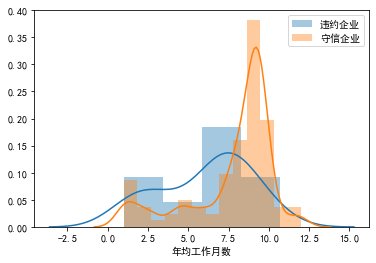

In [8]:
sns.distplot(X_2_bad['年均工作月数'], label="违约企业")
sns.distplot(X_2_good['年均工作月数'], label="守信企业")
plt.legend()

违约企业的月均开发票的数量比较集中，但是似乎不容易把违约企业和守信企业给区分开来,displot难以展露出细节。

使用箱型图绘制了一下,感觉好了些,但是感觉不太能直接用

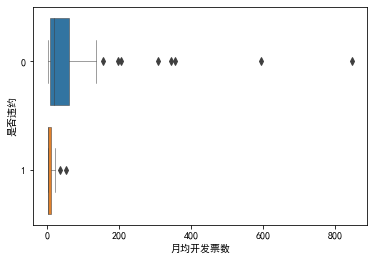

In [9]:
# orient='h'箱型图变为水平的，不然图没法看
sns.boxplot(x=X_2_cleaned['月均开发票数'], y=labels, linewidth=0.5,orient='h')

这个特征就直接判了死刑吧可能

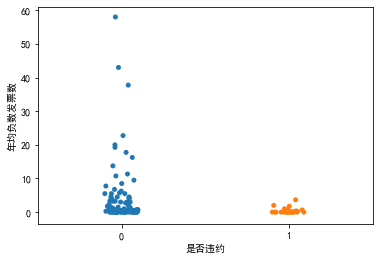

In [10]:
sns.stripplot(x=labels, y="年均负数发票数",data=X_2_cleaned, jitter=True)

上面都只是单变量的可视化,多变量的可视化我就不做了。毕竟没什么戏

## 1.2: 依样画葫芦地处理X3的数据

In [11]:
enterprises_3 = list(X_3['企业代号'].unique())

Sell_feature = []

# 对每个企业的进项发票信息做遍历
for each_enterprise in enterprises_3:
    X_buy = X_3.loc[X_3['企业代号'] == each_enterprise]
    # 得到工作年数，平均一年工作多少月，平均每月能开多少张发票
    years, months_for_each_year, days_for_each_month = cal_times(X_buy)
    # 得到负税率，负数发票的年均数量，作废发票的年均数量，正常进项的年均价税合计
    negative_tax_rate, negative_num_rate, cancel_num_rate, Normal_price_and_tax = cal_bills(years,X_buy)
    enterprise_feature = [months_for_each_year, days_for_each_month, negative_tax_rate, negative_num_rate, cancel_num_rate, Normal_price_and_tax]
    Sell_feature.append(enterprise_feature)


X_3_cleaned = pd.DataFrame(Sell_feature,columns=['年均工作月数','月均开发票数','负税率','年均负数发票数','年均作废发票数','正常出项的年均价税合计'],index=enterprises_3)

# 取出对应数据
X_3_bad = X_3_cleaned.loc[(X_3_cleaned.index).isin(labels_bad.index)]
X_3_good = X_3_cleaned.loc[(X_3_cleaned.index).isin(labels_good.index)]

## 1.2.1: 简单观察X_3的数据

In [12]:
X_3_good.describe()

,年均工作月数,月均开发票数,负税率,年均负数发票数,年均作废发票数,正常出项的年均价税合计
count,96.000000,96.000000,94.000000,96.000000,96.000000,9.600000e+01
mean,7.955729,47.685118,0.030238,22.039931,28.809028,4.293309e+07
std,1.911834,86.443020,0.066211,124.233068,50.004430,1.456000e+08
min,2.000000,1.692308,-0.000000,0.000000,0.250000,0.000000e+00
25%,6.750000,11.321429,0.001482,0.312500,7.625000,9.714741e+05
50%,8.750000,20.505405,0.006997,1.500000,13.875000,8.670835e+06
75%,9.250000,39.383205,0.027857,4.312500,27.812500,2.724836e+07
max,12.000000,633.500000,0.423072,1125.250000,299.250000,1.212223e+09


月均开发票数据也有较为明显的分野呢,像年均作废发票数，正常出项的年均价税合计也是，有比较明显的错位。

负税率就不用看了没用的

In [13]:
X_3_bad.describe()

,年均工作月数,月均开发票数,负税率,年均负数发票数,年均作废发票数,正常出项的年均价税合计
count,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01
mean,5.583333,8.691560,0.032849,1.000000,6.888889,1.863230e+06
std,2.755918,10.202536,0.086845,1.903382,8.404440,4.102009e+06
min,2.000000,1.500000,-0.000000,0.000000,0.000000,1.224733e+04
25%,3.500000,3.248485,-0.000000,0.000000,1.750000,7.765500e+04
50%,5.000000,4.800000,0.000000,0.000000,4.000000,1.961890e+05
75%,7.375000,8.866667,0.020572,0.875000,8.500000,8.300492e+05
max,12.000000,48.343750,0.429137,7.000000,39.333333,1.565879e+07


## 1.2.2： 简单可视化X3的数据

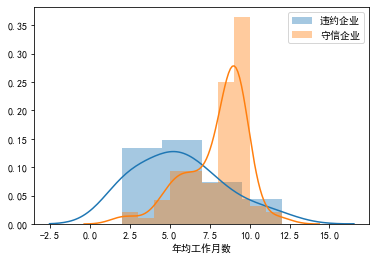

In [14]:
sns.distplot(X_3_bad['年均工作月数'], label="违约企业")
sns.distplot(X_3_good['年均工作月数'], label="守信企业")
plt.legend()

企业在给下游企业开发票的月均开发票数还是有些用的

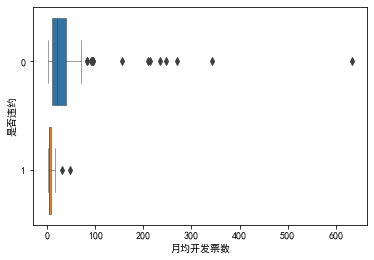

In [15]:
# orient='h'箱型图变为水平的，不然图没法看
sns.boxplot(x=X_3_cleaned['月均开发票数'], y=labels, linewidth=0.5,orient='h')

## 2.1 尝试整合两表数据得到特征

这里有些成功的，也有些失败的，但是都还蛮有意思

### 年均工作月数

表2和表3的年均工作月数同时相乘，可以看到守信企业和违约企业有了较明显的分野

u_d的意思就是up和down的意思，指代上游企业和下游企业了233

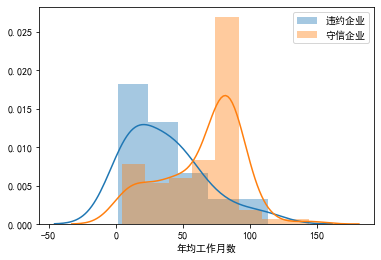

In [16]:
u_d_months_for_each_year = X_2_cleaned['年均工作月数'].multiply(X_3_cleaned['年均工作月数'])

# 取出对应数据
X_ud_months_for_each_year_bad = u_d_months_for_each_year.loc[(X_3_cleaned.index).isin(labels_bad.index)]
X_ud_months_for_each_year_good = u_d_months_for_each_year.loc[(X_3_cleaned.index).isin(labels_good.index)]

sns.distplot(X_ud_months_for_each_year_bad, label="违约企业")
sns.distplot(X_ud_months_for_each_year_good, label="守信企业")
plt.legend()

### 毛利率
在看毛利率之前，先来看一下这个

我在做毛利率的时候发现有负数觉得不对劲，打印出来看一下发现居然有17个企业的营收额为负数。而且居然11个都是守约企业。

我原本期望着能从毛利率上分析出企业是否赚钱,毕竟亏钱的企业想要守约肯定是困难一点的嘛。但是居然是这个样子的。。

而且不同企业的毛利率差距真的太大了,E68企业的上限达到了三千多,然而还有很多企业的毛利率不到1,我都以为是我的代码错了

In [17]:
Earn = X_3_good['正常出项的年均价税合计'].sub(X_2_good['正常进项的年均价税合计'])
na = Earn.loc[Earn<0]
len(na)

11

In [18]:
Earn = X_3_cleaned['正常出项的年均价税合计'].sub(X_2_cleaned['正常进项的年均价税合计'])
Gross_margin = Earn.div(X_2_cleaned['正常进项的年均价税合计'])
Gross_margin.describe()

count     123.000000
mean       69.310376
std       365.009686
min        -1.000000
25%         0.143295
50%         2.050266
75%         8.643788
max      3657.454176
dtype: float64

看这魔幻的世界，i了i了

查阅了一下，E68的名称是 “***花木总公司”

你要说是E67好歹也是个it公司我都更容易信一点。。

In [19]:
X_3_cleaned.iloc[Gross_margin.argmax(),:]

年均工作月数         6.000000e+00
月均开发票数         6.083333e+00
负税率           -0.000000e+00
年均负数发票数        0.000000e+00
年均作废发票数        4.000000e+00
正常出项的年均价税合计    1.353628e+06
Name: E68, dtype: float64

In [20]:
X_2_cleaned.iloc[Gross_margin.argmax(),:]

年均工作月数           1.5
月均开发票数           1.0
负税率             -0.0
年均负数发票数          0.0
年均作废发票数          0.0
正常进项的年均价税合计    370.0
Name: E68, dtype: float64

**彻底打消用毛利率做特征的幻想**

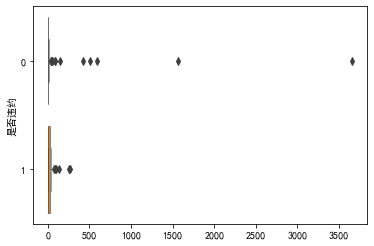

In [21]:
sns.boxplot(x=Gross_margin, y=labels, linewidth=0.5,orient='h')

### 现金流
也可以说没什么用，我都把它删掉了